# Captstone Project: Battle of the Neighborhoods

## Problem

#### Clustering the neighborhoods in Toronto and Highlight their most distinct characteristics

#### BWize Inc., a residential real-estate developer, hired my company to analyze the neighborhoods in Toronto and provide a clustering analysis to provide additional information in their plan to build their condominiums as well as information used for their marketing strategies.

### Libraries needed

In [252]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
import requests
import folium
from geopy.geocoders import Nominatim
from collections import OrderedDict
import matplotlib.pyplot as plt

### Scrapping Data from Wikipedia

In [253]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_ZIP_codes_in_the_Philippines").text
soup = BeautifulSoup(source,'lxml')
real_data=[]
table = soup.find('table', class_='wikitable')
data = table.find_all('td')
for i in data:
    real_data.append(i.text)
content = []
data=[]
counter = 0
for i in real_data:
    if counter < 3:
        i = i.replace("\n","")
        content.append(i)
        counter +=1
    if counter == 3:
        data.append(content)
        content=[]
        counter = 0

### Putting data into Dataframe

In [254]:
neigh_df = pd.DataFrame(data)
neigh_df.columns = ['ZIP code','Neighborhood','City']
#neigh_df.drop(neigh_df.index[0],0,inplace=True)
neigh_df['ZIP code'] = neigh_df['ZIP code'].astype(int)
# Selecting all zip codes in Metro Manila
is_manila = neigh_df['ZIP code'] < 1821
neigh_df = neigh_df[is_manila]
neigh_df

,ZIP code,Neighborhood,City
0,400,International Correspondence School,San Juan
1,401,Asian Development Bank,San Juan
2,410,Radio Bible Class,San Juan
3,420,Bible School on the Air,San Juan
4,550,Febias College of Bible,Valenzuela
...,...,...,...
467,1808,Nangka,Marikina
468,1809,Parang,Marikina
469,1810,Marikina Heights,Marikina
470,1811,Concepcion 2 (SSS Village),Marikina


### Getting the Geospatial data

##### Putting geospatial data into data frame
##### Merging the two data frames

In [4]:
address = 'Metro Manila, Philippines'

geolocator = Nominatim(user_agent="NCR_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NCR are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NCR are 14.5736108, 121.0329706.


In [ ]:
# initialize your variable to None
NCR_df = pd.DataFrame(columns=['ZIP code','Neighborhood','City','Latitude','Longitude'])
counter = 0
# loop until you get the coordinates
for neigh in neigh_df.values:
    print(neigh)
    geolocator = Nominatim(user_agent="NCR_explorer", timeout = 100000)
    print('{}, Metro Manila, Philippines'.format(neigh[1]))
    location = geolocator.geocode('{}, Metro Manila, Philippines'.format(neigh[1]))
    try:
        latitude = location.latitude
        longitude = location.longitude
        NCR_df.loc[counter] = [neigh[0],neigh[1],neigh[2],latitude,longitude]
        print(neigh[1])
        print('Latitude:',latitude)
        print('Longitude:', longitude)
        print("nice")
        counter += 1
    except:
        print("No coordinates for: {}".format(neigh[1]))

##### Converting dataframe to csv file for ease of access in the future

In [13]:
#NCR_df.to_csv('NCR_Geospatial_Data.csv')

#### When internet is not cooperating. Use csv file

In [255]:
NCR_df = pd.read_csv("NCR_Geospatial_Data.csv")
NCR_df.drop('Unnamed: 0',axis=1, inplace=True)
NCR_df.head()

,ZIP code,Neighborhood,City,Latitude,Longitude
0,401,Asian Development Bank,San Juan,14.588076,121.058301
1,550,Febias College of Bible,Valenzuela,14.687899,120.981408
2,702,Citibank,Makati,14.607314,121.078924
3,704,Producers Bank,Makati,14.529699,121.041247
4,707,Canadian Embassy,Makati,14.560645,121.016578


### Visualizing the neighborhoods on a Map

In [256]:
address = "Metro Manila, Philippines"

#creating a geolocator object
geolocator = Nominatim(user_agent = "NCR_explorer")
#getting the coordinates
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical Coordinates of Metro Manila are {}, {}.".format(latitude,longitude))

#Creating the map of Metro Manila
map_NCR = folium.Map(location=[latitude,longitude], zoom_start=10)

#adding the neighborhood markers 
for lat, lng, city, neighborhood in zip(NCR_df['Latitude'],NCR_df['Longitude'],NCR_df['City'],NCR_df['Neighborhood']):
    # Label when you click the marker
    label = '{}, {}'.format(neighborhood, city)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_NCR)

map_NCR

The geographical Coordinates of Metro Manila are 14.5736108, 121.0329706.


### Defining Foursquare Credentials and Version

In [257]:
CLIENT_ID = "BP2YB4GBQPZPVF3FPYEERWMDFRCTOOCYLGLF1SULOKMDNPMD"
CLIENT_SECRET = "0ASIL3MJP4X4XDD3P5NCDV50F3KXVZE2QMTTOE1YACAOVEFS"
VERSION = '20200413'
LIMIT = 100
radius = 500

### Getting Nearby Venues in each Neighborhood

In [8]:
def getNearbyVenues(names,latitudes,longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        #Creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT)
        
        # Executing the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # Return only relevant info
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name'])
        for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    return(nearby_venues)

In [ ]:
NCR_venues = getNearbyVenues(names=NCR_df['Neighborhood'],
                                latitudes=NCR_df['Latitude'],
                                 longitudes=NCR_df['Longitude'],
                                radius=radius)

In [30]:
#NCR_venues.to_csv('NCR_venues.csv')

In [258]:
NCR_venues = pd.read_csv("NCR_venues.csv")
NCR_venues.drop('Unnamed: 0',axis=1, inplace=True)
NCR_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Asian Development Bank,14.588076,121.058301,Craft Coffee Revolution,14.585859,121.059212,Coffee Shop
1,Asian Development Bank,14.588076,121.058301,The Nostalgia Dining Lounge,14.587519,121.059753,Restaurant
2,Asian Development Bank,14.588076,121.058301,Gino's Brick Oven Pizza,14.585791,121.059640,Pizza Place
3,Asian Development Bank,14.588076,121.058301,The Café Mediterranean,14.585967,121.057122,Mediterranean Restaurant
4,Asian Development Bank,14.588076,121.058301,Wildflour Café + Bakery,14.585866,121.059573,Café


In [259]:
NCR_venues.head(10)
NCR_venues.shape

(8908, 7)

In [260]:
shopping = ['Bookstore','Baby Store','Camera Store','Department Store','Duty-free Shop','Electronics Store','Flower Shop','Furniture / Home Store','Gift Shop','Hardware Store','Hobby Shop','Home Service','Kids Store','Mattress Store','Miscellaneous Store','Miscellaneous Shop','Mobile Phone Shop','Music Store','Optical Shop','Paper / Office Supplies Store','Pet Store','Shoe Store','Toy / Game Store','Warehouse Store','Video Game Store','Shopping Plaza','Shopping Mall','Shop & Service','Discount Store','Bridal Shop','Shoe Repair']
dessert_cafe_tea = ['Coffee Shop','Bubble Tea Shop','Café',"Cafeteria",'Candy Shop','Candy Store','College Cafeteria','Cupcake Shop','Dessert Shop','Donut Shop','Frozen Yogurt Shop','Shop','Ice Cream Shop','Juice Bar','Pet Café','Tea Room','Creperie','Chocolate Shop']
vehicle_transport = ['Airport','Airport Terminal','Airport Service','Autoshop','Automotive Shop','Bike Rental / Bike Share','Bike Shop','Bike Rental','Boat or Ferry','Border Crossing','Bus Station','Bus Stop','Car Wash','Gas Station','Harbor / Marina','Intersection','Light Rail Station','Metro Station','Parking','Pedestrian Plaza','Pier','Rental Car Location','Road','Shipping Store','Taxi','Toll Plaza','Train Station','Travel & Transport', 'Tunnel','Cruise','Building','General Travel']
arts_culture = ['Amphitheater','Antique Shop','Art Gallery','Art Museum','Arts & Crafts Store','Film Studio','History Museum','Monument / Landmark','Museum','Outdoor Sculpture','Photography Lab','Photography Studio','Public Art','Record Shop','Science Museum','Planetarium','Fountain','Sculpture Garden']
restaurants = ['American Restaurant','Asian Restaurant','Australian Restaurant','BBQ Joint','Bed & Breakfast','Bistro','Breakfast Spot','Buffet','Cajun / Creole Restaurant','Cantonese Restaurant','Cha Chaan Teng','Chinese Restaurant','Chinese Aristocrat Restaurant','Comfort Food Restaurant','Dim Sum Restaurant','Diner','Doner Restaurant','Dumpling Restaurant','Eastern European Restaurant','Empanada Restaurant','English Restaurant','Filipino Restaurant','Food','Food & Drink Shop','Food Court','Food Service','Food Stand','French Restaurant','Gastropub','German Restaurant','Gourmet Shop','Greek Restaurant','Hunan Restaurant','Indian Restaurant','Indonesian Restaurant','Italian Restaurant','Japanese Curry Restaurant','Japanese Restaurant','Kebab Restaurant','Korean Restaurant','Latin American Restaurant','Malay Restaurant','Mediterranean Restaurant','Mexican Restaurant','Mexican Restaurant','Middle Eastern Restaurant','Modern European Restaurant','Mongolian Restaurant','New American Restaurant','Noodle House','Okonomiyaki Restaurant','Paella Restaurant','Persian Restaurant', 'Soup Place','Soba Restaurant','South American Restaurant','Peruvian Restaurant','Portuguese Restaurant','Ramen Restaurant','Restaurant','Salad Place','Seafood Restaurant','Southern / Soul Food Restaurant','Spanish Restaurant','Steakhouse','Sushi Restaurant','Szechuan Restaurant','Tapas Restaurant','Tex-Mex Restaurant','Thai Restaurant','Theme Restaurant','Tonkatsu Restaurant','Udon Restaurant','Vegetarian / Vegan Restaurant','Vietnamese Restaurant','Gourmet','Molecular Gastronomy Restaurant']
fast_food = ['Burrito Place','Fish & Chips Shop','Food Truck','Fried Chicken Joint','Hot Dog Joint','Snack Place','Pizza Place','Sandwich Place','Burger Joint','Fast Food Restaurant','Shawarma Place','Taco Place','Wings Joint']
entertainment = ['Event Place','Arcade','Casino','Gaming Cafe','General Entertainment','Concert Hall','Convention Center','Event Service','Event Space','Internet Cafe','Movie Theater','Multiplex','Radio Station','Smoke Shop','Stadium','Theater','Vape Shop','Music Venue','Performing Arts Venue','Event Place','Club House','Comedy Club']
sports_fitness = ['Athletics & Sports','Badminton Court','Baseball Field','Basketball Court','Basketball Stadium','Bowling Alley','Boxing Gym','Camp Ground','College Track','Dance Studio','Field','Golf Course','Golf Driving Range','Gun Range','Gym','Gym / Fitness Center','Gym Pool','Martial Arts Dojo','Outdoors & Recreation','Recreation Center','Rugby Pitch','Soccer Stadium','Soccer Field','Sports Bar','Sports Club','Tennis Court','Sporting Goods Shop','Track','Yoga Studio','Skating Rink','Track Stadium','Dive Shop','Rock Climbing Spot']
cosmetics_clothes_wellness = ['Boutique','Clothing Store','Cosmetics Shop','Health & Beauty Service','Jewelry Store','Lingerie Store','Massage Studio',"Men's Store",'Nail Salon','Pet Service','Salon / Barbershop','Spa','Tailor Shop',"Women's Store",'Accessories Store']
convenience_food_essentials = ['Bagel Shop','Bakery','Big Box Store','Butcher','Convenience Store','Deli / Bodega','Drugstore',"Farmers Market",'Fish Market','Fishing Store','Flea Market','Fruit & Vegetable Store','Grocery Store','Health Food Store','Laundromat','Market','Organic Grocery','Pharmacy','Supermarket']
business_hub = ['Bank','Business Center','Government Building','Insurance Office','Non-Profit','Office','Post Office','Tech Startup','Coworking Space']
night_life = ['Bar','Beer Bar','Beer Garden','Speakeasy','Brewery','Cocktail Bar','Hookah Bar','Hotel Bar','Karaoke Bar','Nightclub','Other Nightlife','Pub','Wine Bar','Whisky Bar','Wine Shop','Winery','Liquor Store','Dive Bar','Rock Club','Vape Store']
tourist_destination = ['Beach','Beach Bar','Garden','Garden Center','Historic Site','Lake','National Park','Other Great Outdoors','Park','Playground','Plaza','Pool','Pool Hall','Resort','River','Scenic Lookout','Theme Park','Theme Park Ride / Attraction','Water Park','Zoo','Indoor Play Area','Campground','Dog Run','Construction & Landscaping','Nature Preserve']
residential = ['Boarding House','Residential Building (Apartment / Condo)']
city_essentials = ['Hospital','Medical Center','Veterinarian','Church','Music School','School']
accomodations = ['Hostel','Hotel','Hotel Pool','Lounge','Motel','Rest Area','Roof Deck','Travel Lounge']

In [261]:
venue_type = []
venue_label={}
counter=0
for i in NCR_venues['Venue Category']:
    if i in shopping:
        venue_label[counter]="Gadgets, Hardware, Toys, etc."
        
    elif i in dessert_cafe_tea:
        venue_label[counter]="Cafe/Tea/Dessert"
    
    elif i in vehicle_transport:
        venue_label[counter]="Vehicle/Transport Related"
    
    elif i in arts_culture:
        venue_label[counter]="Art/Culture/Museum"
    
    elif i in restaurants:
        venue_label[counter]="Restaurant"
    
    elif i in fast_food:
        venue_label[counter]="Fast Food" 
    
    elif i in entertainment:
        venue_label[counter]="Entertainment" 
    
    elif i in sports_fitness:
        venue_label[counter]="Sports & Fitness" 
    
    elif i in cosmetics_clothes_wellness:
        venue_label[counter]="Cosmetics, Clothes, Beauty and Health Services" 
    
    elif i in convenience_food_essentials:
        venue_label[counter]="Convenience Stores and Food Essentials" 
    
    elif i in business_hub:
        venue_label[counter]="Business Hub" 
    
    elif i in night_life:
        venue_label[counter]="Night Life" 
    
    elif i in tourist_destination:
        venue_label[counter]="Tourist Destination" 
    
    elif i in residential:
        venue_label[counter]="Residential" 
    
    elif i in city_essentials:
        venue_label[counter]="City Essentials" 
    
    elif i in accomodations:
        venue_label[counter]="Accomodation" 
    
    else:
        venue_label[counter]="None"
    counter += 1

venue_type.append(venue_label)
venue_type = pd.DataFrame(venue_type)

NCR_venues = NCR_venues.join(venue_type.T)
NCR_venues.rename(columns={0: "Venue Type"},inplace=True)
NCR_venues.head(50)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Type
0,Asian Development Bank,14.588076,121.058301,Craft Coffee Revolution,14.585859,121.059212,Coffee Shop,Cafe/Tea/Dessert
1,Asian Development Bank,14.588076,121.058301,The Nostalgia Dining Lounge,14.587519,121.059753,Restaurant,Restaurant
2,Asian Development Bank,14.588076,121.058301,Gino's Brick Oven Pizza,14.585791,121.059640,Pizza Place,Fast Food
3,Asian Development Bank,14.588076,121.058301,The Café Mediterranean,14.585967,121.057122,Mediterranean Restaurant,Restaurant
4,Asian Development Bank,14.588076,121.058301,Wildflour Café + Bakery,14.585866,121.059573,Café,Cafe/Tea/Dessert
5,Asian Development Bank,14.588076,121.058301,Beauty Bar,14.585759,121.059815,Cosmetics Shop,"Cosmetics, Clothes, Beauty and Health Services"
6,Asian Development Bank,14.588076,121.058301,Polecats Manila,14.586639,121.061063,Gym / Fitness Center,Sports & Fitness
7,Asian Development Bank,14.588076,121.058301,yoga+,14.585829,121.059084,Yoga Studio,Sports & Fitness
8,Asian Development Bank,14.588076,121.058301,Kuya J Restaurant,14.586212,121.056636,Filipino Restaurant,Restaurant
9,Asian Development Bank,14.588076,121.058301,Toby's Estate Coffee Roasters,14.587986,121.061060,Coffee Shop,Cafe/Tea/Dessert


In [262]:
#NCR_venues.to_csv('NCR_venues_categorized.csv')

In [263]:
NCR_venue_type_std = NCR_venues.groupby('Venue Type').count()
NCR_venue_type_std.drop("Neighborhood",axis=1,inplace= True)
NCR_venue_type_std.drop("Neighborhood Latitude",axis=1,inplace= True)
NCR_venue_type_std.drop("Neighborhood Longitude",axis=1,inplace= True)
NCR_venue_type_std.drop("Venue",axis=1,inplace= True)
NCR_venue_type_std.drop("Venue Latitude",axis=1,inplace= True)
NCR_venue_type_std.drop("Venue Longitude",axis=1,inplace= True)
NCR_venue_type_std

,Venue Category
Venue Type,
Accomodation,158
Art/Culture/Museum,109
Business Hub,41
Cafe/Tea/Dessert,1505
City Essentials,26
Convenience Stores and Food Essentials,996
"Cosmetics, Clothes, Beauty and Health Services",520
Entertainment,176
Fast Food,1127


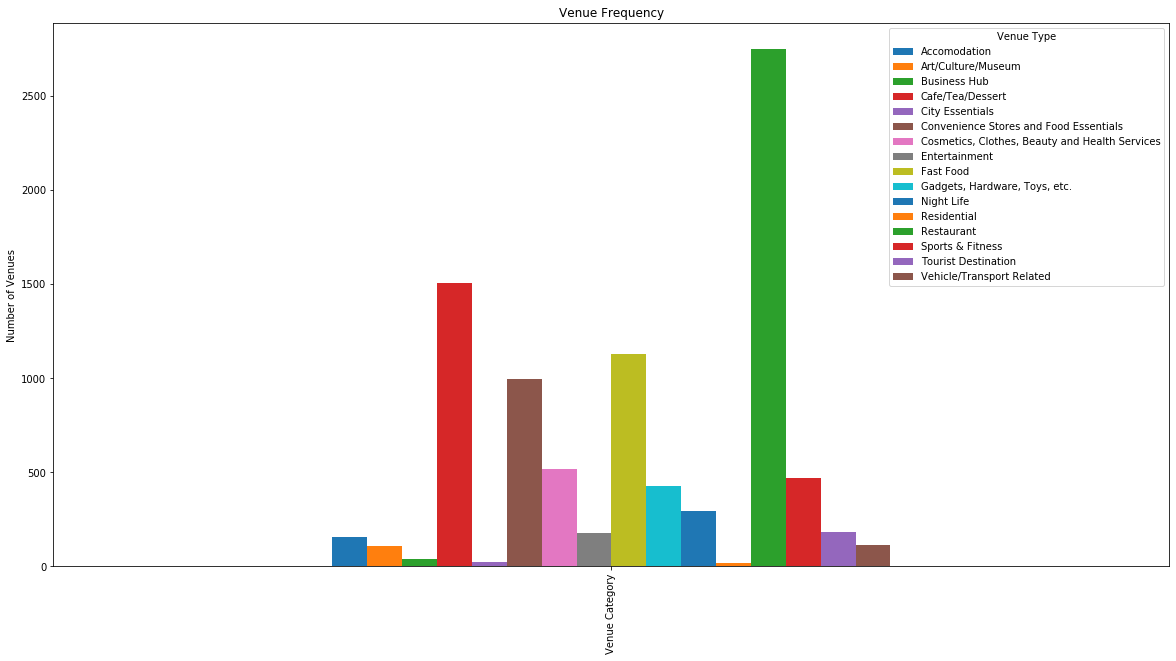

In [264]:
NCR_venue_type_std.T.plot(kind='bar',figsize=(20, 10))

plt.title('Venue Frequency') # add a title to the histogram
plt.ylabel('Number of Venues') # add y-label

plt.show()

In [20]:
NCR_venue_type_std_imp = NCR_venue_type_std.loc['Residential']/NCR_venue_type_std
NCR_venue_type_std_imp.rename(columns={"Venue Category": "Importance factor"},inplace=True)
NCR_venue_type_std_imp.head(20)

,Importance factor
Venue Type,
Accomodation,0.107595
Art/Culture/Museum,0.155963
Business Hub,0.414634
Cafe/Tea/Dessert,0.011296
City Essentials,0.653846
Convenience Stores and Food Essentials,0.017068
"Cosmetics, Clothes, Beauty and Health Services",0.032692
Entertainment,0.096591
Fast Food,0.015084


### Converting Categorical data into int

In [43]:
# one hot encoding
NCR_onehot = pd.get_dummies(NCR_venues[['Venue Type']], prefix="", prefix_sep="")
# Adding neighborhood column back
NCR_onehot['Neighborhood'] = NCR_venues['Neighborhood']
# Moving neighborhood column to the first column
fixed_columns = [NCR_onehot.columns[-1]] + list(NCR_onehot.columns[:-1])
#fixed_columns.pop(-1)
NCR_onehot = NCR_onehot[fixed_columns]

In [44]:
NCR_onehot_std = NCR_onehot.T
NCR_onehot_std.drop(['Neighborhood'],inplace = True)
print(NCR_onehot_std.shape)
print(NCR_venue_type_std_imp.shape)
#NCR_onehot_std = NCR_onehot_std.astype(float)
print(NCR_onehot_std.dtypes,NCR_venue_type_std_imp.dtypes)
#NCR_onehot_std1 = NCR_onehot_std.multiply(NCR_venue_type_std_imp,axis="index")
NCR_onehot_std = NCR_onehot_std.mul(NCR_venue_type_std_imp['Importance factor'],axis='index')
NCR_onehot_std

(16, 8908)
(16, 1)
0       object
1       object
2       object
3       object
4       object
         ...  
8903    object
8904    object
8905    object
8906    object
8907    object
Length: 8908, dtype: object Importance factor    float64
dtype: object


,0,1,2,3,4,5,6,7,8,9,...,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907
Accomodation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Art/Culture/Museum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Business Hub,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cafe/Tea/Dessert,0.0112957,0,0,0,0.0112957,0,0,0,0,0.0112957,...,0.0112957,0,0,0,0,0,0,0,0,0
City Essentials,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Convenience Stores and Food Essentials,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Cosmetics, Clothes, Beauty and Health Services",0,0,0,0,0,0.0326923,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Entertainment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Fast Food,0,0,0.0150843,0,0,0,0,0,0,0,...,0,0,0,0,0.0150843,0,0,0,0,0
"Gadgets, Hardware, Toys, etc.",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Getting the mean occurence of different venues 

In [45]:
NCR_onehot_std = NCR_onehot_std.T
NCR_onehot_std['Neighborhood'] = NCR_venues['Neighborhood'].T
#fixed_columns = [NCR_onehot_std.columns[-1]] + list(NCR_onehot_std.columns[:-1])
#NCR_onehot_std.columns[-1]] + list(NCR_onehot_std.columns[:-1])
#NCR_onehot_std = NCR_onehot_std[fixed_columns].T
#NCR_grouped = NCR_onehot_std.Gr
NCR_onehot_std.head(50)

,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,City Essentials,Convenience Stores and Food Essentials,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related,Neighborhood
0,0,0,0,0.0112957,0,0,0,0,0,0,0,0,0,0,0,0,Asian Development Bank
1,0,0,0,0,0,0,0,0,0,0,0,0,0.00618182,0,0,0,Asian Development Bank
2,0,0,0,0,0,0,0,0,0.0150843,0,0,0,0,0,0,0,Asian Development Bank
3,0,0,0,0,0,0,0,0,0,0,0,0,0.00618182,0,0,0,Asian Development Bank
4,0,0,0,0.0112957,0,0,0,0,0,0,0,0,0,0,0,0,Asian Development Bank
5,0,0,0,0,0,0,0.0326923,0,0,0,0,0,0,0,0,0,Asian Development Bank
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0362473,0,0,Asian Development Bank
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0362473,0,0,Asian Development Bank
8,0,0,0,0,0,0,0,0,0,0,0,0,0.00618182,0,0,0,Asian Development Bank
9,0,0,0,0.0112957,0,0,0,0,0,0,0,0,0,0,0,0,Asian Development Bank


In [35]:
NCR_grouped = NCR_onehot_std.groupby('Neighborhood').sum().reset_index()
NCR_grouped.head(20)

,Neighborhood,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,City Essentials,Convenience Stores and Food Essentials,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related
0,Acacia,0.000000,0.000000,0.0,0.011296,0.000000,0.034137,0.000000,0.000000,0.030169,0.00,0.000000,0.0,0.000000,0.072495,0.000000,0.150442
1,Aeropark Subdivision,0.000000,0.000000,0.0,0.045183,0.000000,0.051205,0.098077,0.000000,0.075421,0.00,0.057627,0.0,0.049455,0.000000,0.000000,0.150442
2,Alabang,0.215190,0.000000,0.0,0.135548,0.000000,0.153614,0.294231,0.096591,0.165927,0.24,0.172881,0.0,0.123636,0.217484,0.187845,0.000000
3,Alicia,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015084,0.00,0.000000,0.0,0.006182,0.036247,0.000000,0.000000
4,Almanza,0.107595,0.000000,0.0,0.158140,0.000000,0.068273,0.261538,0.096591,0.196096,0.24,0.000000,0.0,0.080364,0.036247,0.093923,0.000000
5,Amihan,0.000000,0.000000,0.0,0.033887,0.000000,0.051205,0.000000,0.000000,0.015084,0.00,0.057627,0.0,0.030909,0.036247,0.000000,0.000000
6,Angela Village,0.000000,0.000000,0.0,0.000000,0.000000,0.051205,0.000000,0.000000,0.015084,0.04,0.000000,0.0,0.012364,0.000000,0.093923,0.000000
7,Apolonio Samson,0.000000,0.000000,0.0,0.000000,0.000000,0.017068,0.000000,0.000000,0.000000,0.04,0.057627,0.0,0.006182,0.036247,0.000000,0.000000
8,Araneta Center,0.322785,0.311927,0.0,0.271096,0.000000,0.102410,0.130769,0.482955,0.226264,0.36,0.172881,0.0,0.154545,0.108742,0.093923,0.000000
9,Araneta Subdivision,0.000000,0.000000,0.0,0.000000,0.000000,0.017068,0.000000,0.000000,0.015084,0.00,0.000000,0.0,0.006182,0.000000,0.000000,0.000000


### Modelling using KMeans Clustering

#### Finding the best K.

#### Elbow method
###### We plot the sum of squared errors from different values of K. 

Text(0, 0.5, 'Sum of squared distance')

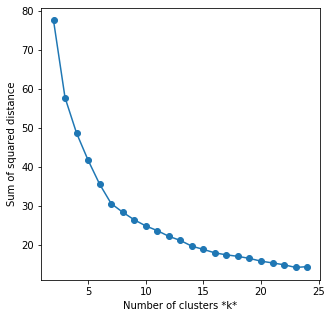

In [26]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Run the Kmeans algorithm and get the index of data points clusters
# sse is sum of squared distance list
sse = []

# k_list is the list of range in between we want to find clusters for
k_list = list(range(2, 25))
NCR_grouped_clustering = NCR_grouped.drop('Neighborhood', 1)
for k in k_list:
    # km_model is the KMeans where we define the model for fitting the data
    kmeans = KMeans(n_clusters=k, random_state=30, init="random",n_init=1000,max_iter=1000).fit(NCR_grouped_clustering)
    sse.append(kmeans.inertia_)

# Plot sse against k and find the value of k where it starts to flatten down and make angle like elbow.
plt.figure(figsize=(5, 5))
plt.plot(k_list, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

##### Looking at the figure above, We can see the 'Elbow' or where the slope stops steeply decreasing on K = 7

#### The number of clusters we are going to use is 7.

#### We fit the data to the Kmeans model and get the cluster labels of the different neighborhoods

In [232]:
NCR_kmeans = KMeans(n_clusters=7, random_state=30,init="random",n_init=1000,max_iter=1000).fit(NCR_grouped_clustering)
NCR_kmeans.labels_

array([2, 2, 3, 2, 3, 2, 2, 2, 3, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 6, 6,
       2, 4, 2, 2, 6, 3, 4, 2, 5, 2, 3, 2, 2, 2, 4, 2, 3, 2, 5, 4, 2, 4,
       2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 3, 0, 4, 2, 2, 4,
       5, 2, 2, 2, 2, 2, 4, 3, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 4, 6, 4, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 5, 2, 2, 5, 4, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 6, 3, 2, 2, 2, 4, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 6, 2, 2,
       2, 2, 2, 5, 2, 2, 3, 2, 2, 3, 4, 3, 2, 3, 2, 3, 2, 4, 2, 2, 4, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 6, 2, 5, 2, 2, 2, 2, 2, 2,
       3, 5, 2, 2, 2, 2, 2, 2, 3, 2, 4, 2, 2, 6, 2, 5, 3, 2, 2, 6, 2, 4,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 3,

#### We append the labels to the data frame

In [233]:
NCR_grouped.drop('Cluster Labels',1,inplace =True)
NCR_grouped.insert(0, 'Cluster Labels', NCR_kmeans.labels_)
NCR_grouped.head()

,Cluster Labels,Neighborhood,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,City Essentials,Convenience Stores and Food Essentials,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related
0,2,Acacia,0.000000,0.0,0.0,0.011296,0.0,0.034137,0.000000,0.000000,0.030169,0.00,0.000000,0.0,0.000000,0.072495,0.000000,0.150442
1,2,Aeropark Subdivision,0.000000,0.0,0.0,0.045183,0.0,0.051205,0.098077,0.000000,0.075421,0.00,0.057627,0.0,0.049455,0.000000,0.000000,0.150442
2,3,Alabang,0.215190,0.0,0.0,0.135548,0.0,0.153614,0.294231,0.096591,0.165927,0.24,0.172881,0.0,0.123636,0.217484,0.187845,0.000000
3,2,Alicia,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.015084,0.00,0.000000,0.0,0.006182,0.036247,0.000000,0.000000
4,3,Almanza,0.107595,0.0,0.0,0.158140,0.0,0.068273,0.261538,0.096591,0.196096,0.24,0.000000,0.0,0.080364,0.036247,0.093923,0.000000


In [234]:
NCR_merged = NCR_df
NCR_merged = NCR_merged.join(NCR_grouped.set_index('Neighborhood'), on ='Neighborhood')
NCR_merged.dropna(inplace = True)
NCR_merged['Cluster Labels'] = NCR_merged['Cluster Labels'].astype(int)
NCR_merged.head()

,ZIP code,Neighborhood,City,Latitude,Longitude,Cluster Labels,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,...,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related
0,401,Asian Development Bank,San Juan,14.588076,121.058301,1,0.430380,0.623853,0.000000,0.542193,...,0.850000,0.193182,0.241349,0.48,0.000000,0.0,0.358545,0.434968,0.187845,0.0
1,550,Febias College of Bible,Valenzuela,14.687899,120.981408,2,0.000000,0.000000,0.000000,0.011296,...,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.006182,0.036247,0.000000,0.0
2,702,Citibank,Makati,14.607314,121.078924,5,0.107595,0.000000,0.414634,0.203322,...,0.425000,0.772727,0.165927,0.24,0.115254,2.0,0.166909,0.181237,0.093923,0.0
3,704,Producers Bank,Makati,14.529699,121.041247,2,0.000000,0.155963,0.000000,0.011296,...,0.032692,0.000000,0.045253,0.00,0.000000,0.0,0.055636,0.217484,0.093923,0.0
4,707,Canadian Embassy,Makati,14.560645,121.016578,5,0.000000,0.155963,0.414634,0.045183,...,0.032692,0.000000,0.030169,0.00,0.172881,1.0,0.037091,0.217484,0.000000,0.0


#### Visualize the clusters on the map

In [ ]:
counter = 1
for i in rainbow:
    print(i,counter)
    counter += 1

In [235]:
# create map
kmeans_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
km_k = len(NCR_kmeans.labels_)
#set color scheme for the clusters
x = np.arange(km_k)
ys = [i + x + (i*x)**2 for i in range (km_k)]
colors_array = cm.Accent(np.linspace(0,1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(NCR_merged['Latitude'],NCR_merged['Longitude'],NCR_merged['Neighborhood'],NCR_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color=rainbow[(cluster+1)*45-5],
    fill=False,
    fill_color=rainbow[(cluster+1)*45-5],
    fill_opacity=0.7,
    legend_name='Clusters in Metro Manila').add_to(kmeans_map_clusters)
kmeans_map_clusters

#### See the number of neighborhoods per cluster

In [236]:
km_merged_group = NCR_grouped.groupby('Cluster Labels').count().reset_index()
km_merged_group

,Cluster Labels,Neighborhood,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,City Essentials,Convenience Stores and Food Essentials,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related
0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258
3,3,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
4,4,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
5,5,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
6,6,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13


#### Classification of Neighborhoods in Metro Manila using KMeans Clustering

In [240]:
NCR_clustered = NCR_grouped.groupby('Cluster Labels').mean()
NCR_clustered

,Accomodation,Art/Culture/Museum,Business Hub,Cafe/Tea/Dessert,City Essentials,Convenience Stores and Food Essentials,"Cosmetics, Clothes, Beauty and Health Services",Entertainment,Fast Food,"Gadgets, Hardware, Toys, etc.",Night Life,Residential,Restaurant,Sports & Fitness,Tourist Destination,Vehicle/Transport Related
Cluster Labels,,,,,,,,,,,,,,,,
0,0.403481,1.169725,0.310976,0.036711,0.653846,0.021335,0.008173,0.000000,0.049024,0.020000,0.072034,0.000000,0.063364,0.036247,0.587017,0.075221
1,0.430380,0.623853,0.000000,0.542193,3.923077,0.170683,0.850000,0.193182,0.241349,0.480000,0.000000,0.000000,0.358545,0.434968,0.187845,0.000000
2,0.016264,0.018740,0.000000,0.023379,0.000000,0.035592,0.022555,0.016098,0.030695,0.017984,0.027250,0.000000,0.025494,0.032735,0.033856,0.037902
3,0.162644,0.076168,0.000000,0.144742,0.000000,0.075418,0.156619,0.217891,0.112957,0.206512,0.117935,0.000000,0.121480,0.093569,0.065527,0.034987
4,0.039850,0.034659,0.506775,0.071958,0.000000,0.085341,0.043590,0.042929,0.055309,0.034074,0.085374,0.000000,0.078990,0.060412,0.048701,0.161586
5,0.132425,0.107975,0.127580,0.097317,0.000000,0.073525,0.123225,0.089161,0.100949,0.076923,0.132986,1.307692,0.089874,0.105954,0.057799,0.046290
6,0.074489,0.095977,0.031895,0.065167,0.804734,0.081403,0.060355,0.074301,0.075421,0.076923,0.044329,0.000000,0.098909,0.072495,0.065023,0.034717


#### Cluster 1

##### Arts, Culture, Science District

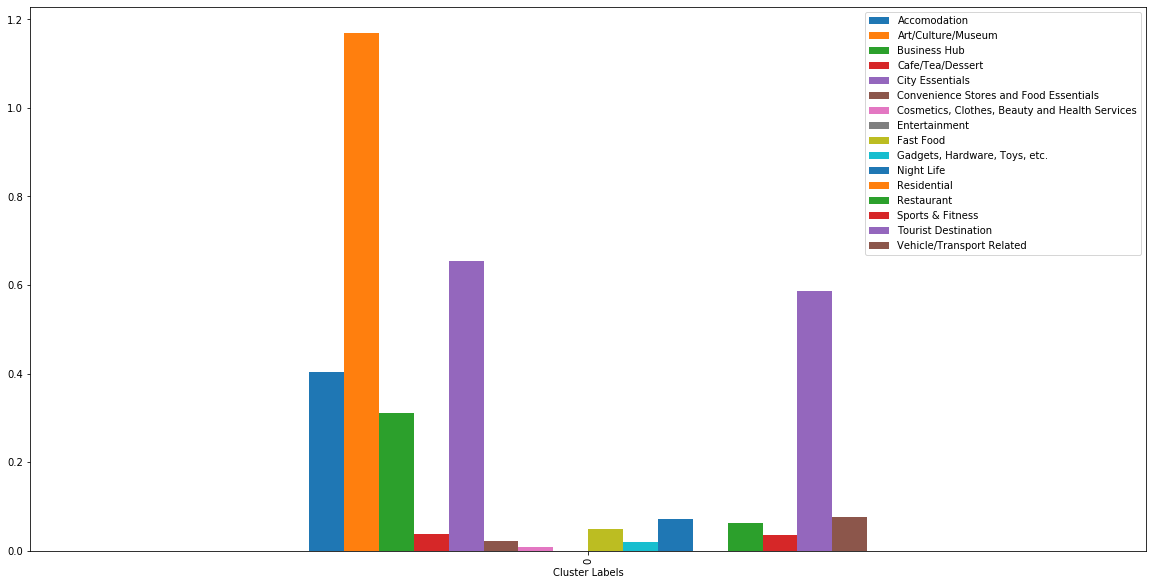

In [243]:
NCR_clustered.loc[[0]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 2

##### Downtown Church, Hospital, School Zone 

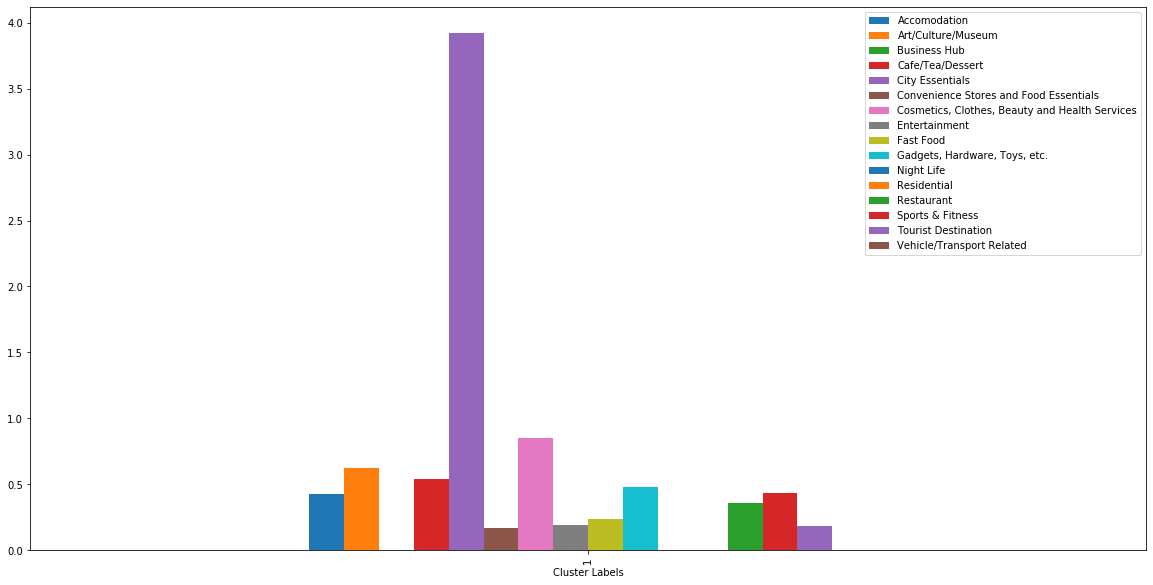

In [244]:
NCR_clustered.loc[[1]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 3

##### City Center

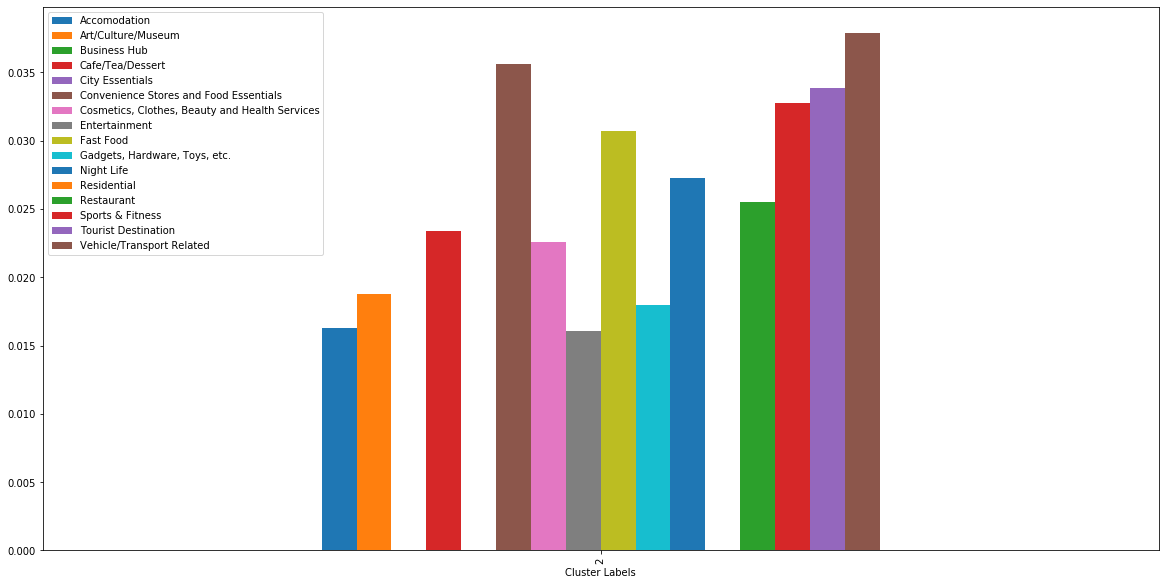

In [245]:
NCR_clustered.loc[[2]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 4

##### Entertainment and Shopping District

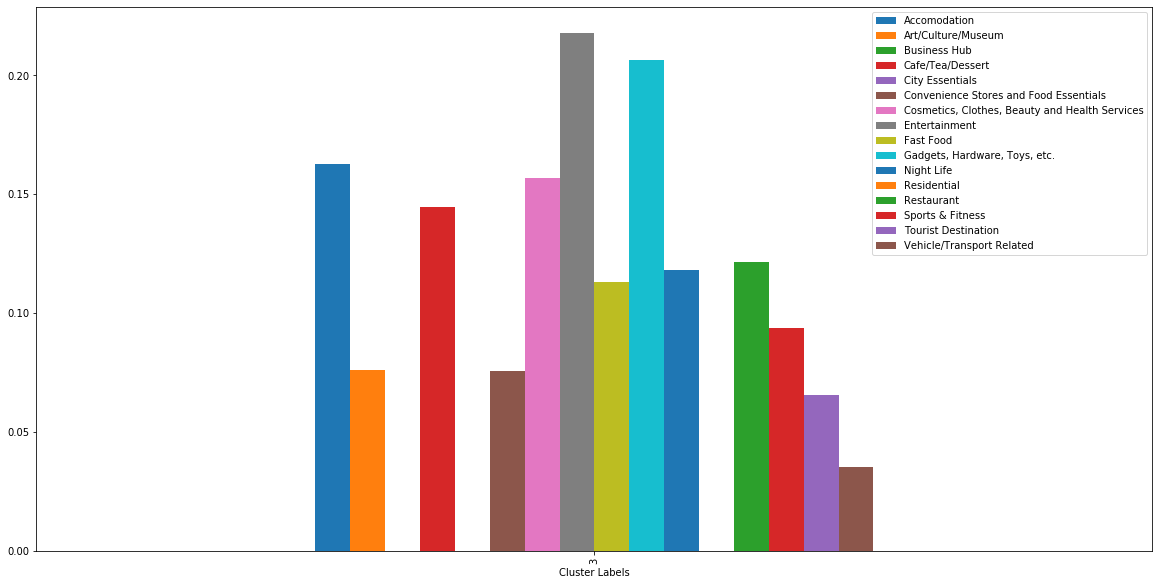

In [246]:
NCR_clustered.loc[[3]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 5

##### Business District

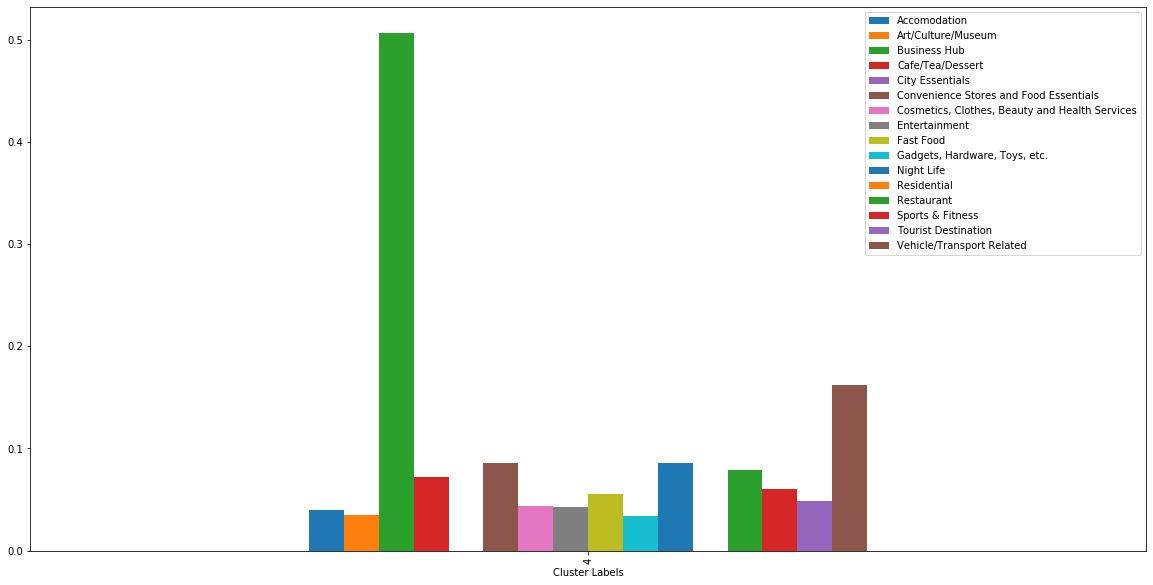

In [247]:
NCR_clustered.loc[[4]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 6

##### Residential District

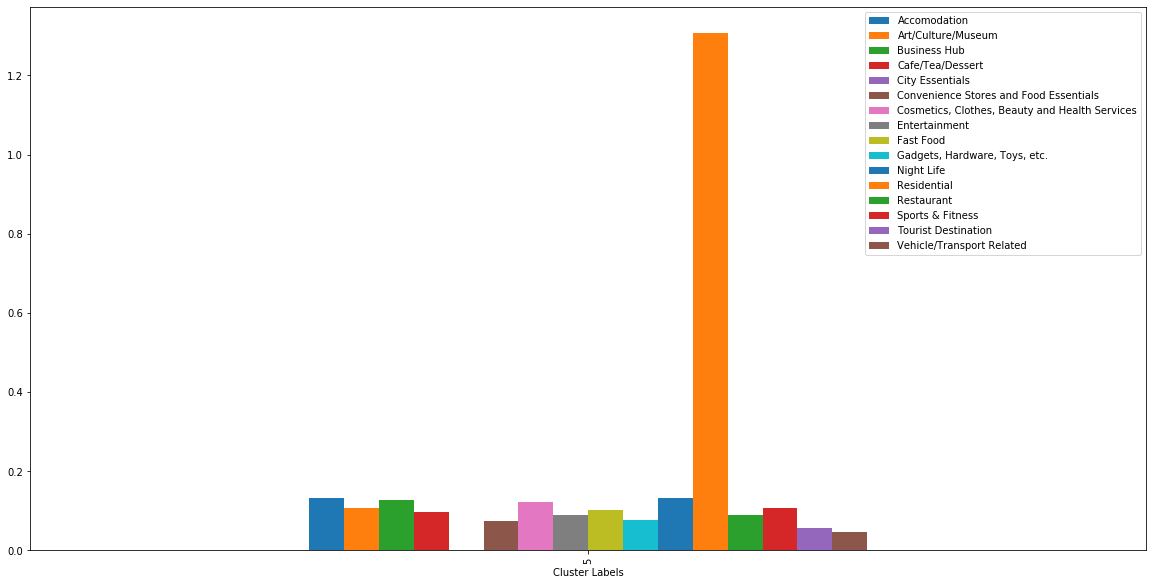

In [248]:
NCR_clustered.loc[[5]].plot(kind='bar',figsize=(20,10))
plt.show()

#### Cluster 7

##### Low profile Church, Hospital, School Zone

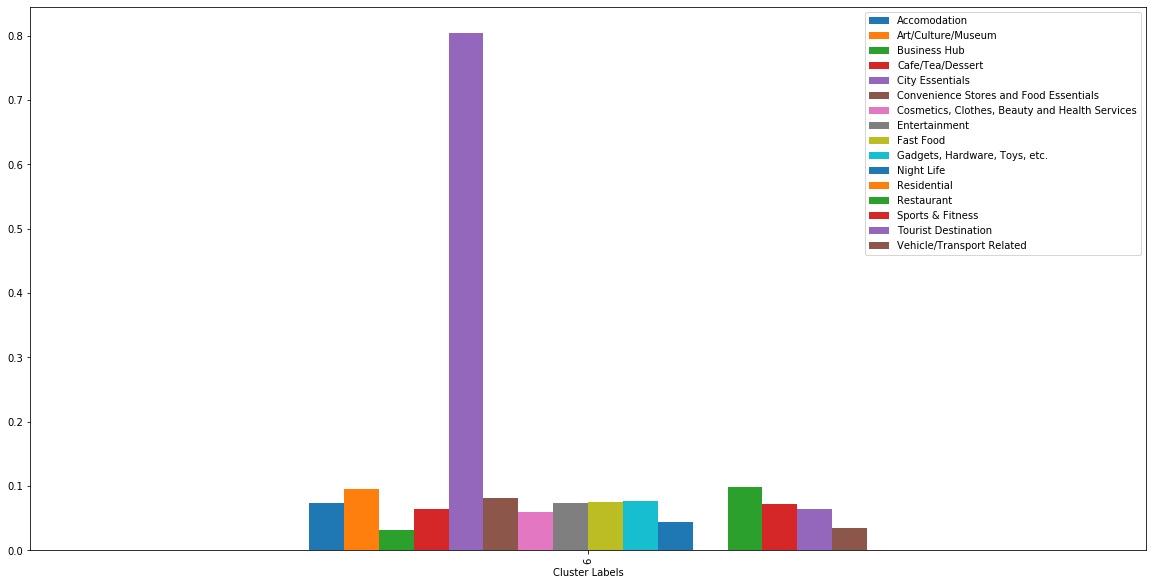

In [249]:
NCR_clustered.loc[[6]].plot(kind='bar',figsize=(20,10))
plt.show()

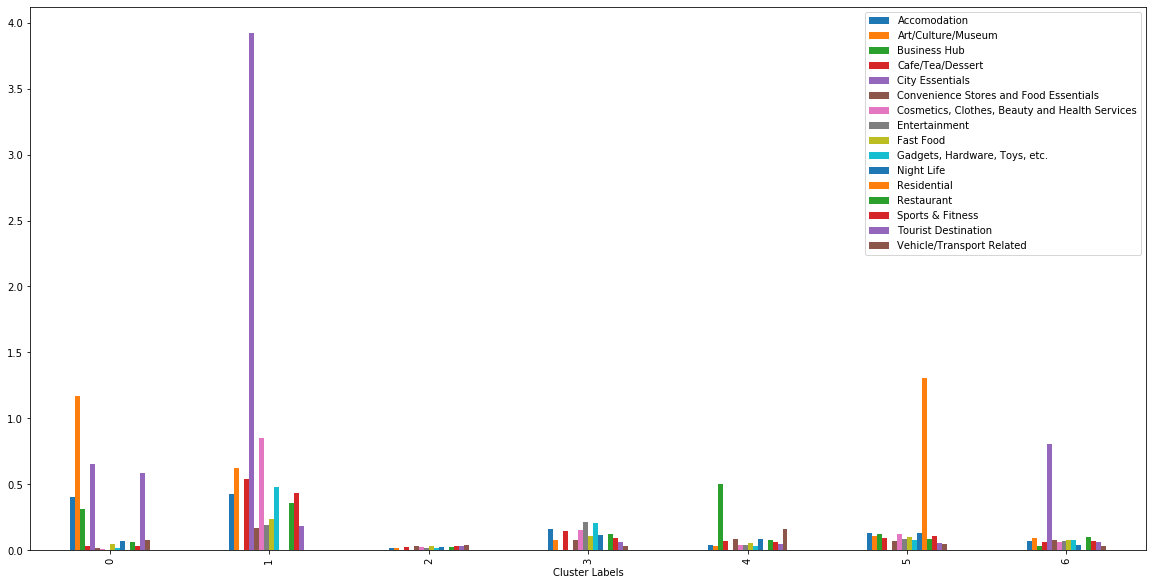

In [250]:
NCR_clustered.plot(kind='bar',figsize=(20,10))
plt.show()